## Initial Process

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## Import CSV Data

In [2]:
amnist_data = pd.read_csv("MNIST_train.csv")


In [3]:
amnist_data

,Unnamed: 0,index,labels,0,1,2,3,4,5,6,...,774,775,776,777,778,779,780,781,782,783
0,0,0,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,3,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,4,9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,59995,59995,8,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,59996,59996,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,59997,59997,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,59998,59998,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
amnist_data.shape

(60000, 787)

In [5]:
X = amnist_data.to_numpy()

In [6]:
y = X[:,2]
y

array([5, 0, 4, ..., 5, 6, 8])

In [7]:
set(y)

{np.int64(0),
 np.int64(1),
 np.int64(2),
 np.int64(3),
 np.int64(4),
 np.int64(5),
 np.int64(6),
 np.int64(7),
 np.int64(8),
 np.int64(9)}

In [8]:
X = X[:, 3:]
X.shape

(60000, 784)

In [9]:
obs_1 = X[1, :]
obs_1

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  51, 159, 253,
       159,  50,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  48, 238,
       252, 252, 252, 237,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [10]:
X[1].max()

np.int64(255)

In [11]:
obs_1 = obs_1.reshape(28, 28)
obs_1

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,  51, 159, 253, 159,  50,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,  48, 238, 252, 252, 252, 237,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  

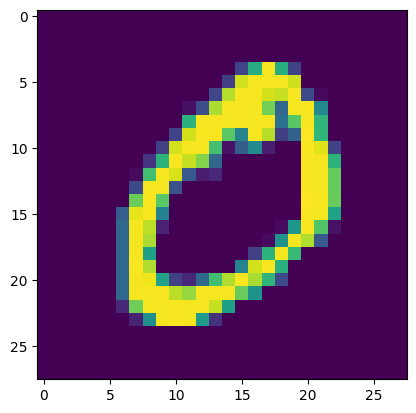

In [12]:
plt.imshow(obs_1)

In [13]:
from scipy.stats import multivariate_normal as mvn

In [14]:
class GaussNB():

  def fit(self, X, y, epsilon = 1e-3):
    self.likelihoods = dict()
    self.priors = dict()
    self.K = set(y.astype(int))

    for k in self.K:
      X_k = X[y==k]
      # Naive Assumption: Observations are linearly independant of each other
      self.likelihoods[k] = {"mean": X_k.mean(axis=0), "cov":X_k.var(axis=0)+epsilon}
      self.priors[k] = len(X_k) / len(X)

  def predict(self, X):

    N, D = X.shape
    P_hat = np.zeros((N, len(self.K)))

    for k, l in self.likelihoods.items():
      P_hat[:,k] = mvn.logpdf(X, l["mean"], l["cov"]) + np.log(self.priors[k])

    return P_hat.argmax(axis=1)

In [15]:
gnb = GaussNB()
gnb.fit(X,y)
y_hat = gnb.predict(X)

In [16]:
def accuracy(y, y_hat):
  return np.mean(y==y_hat)

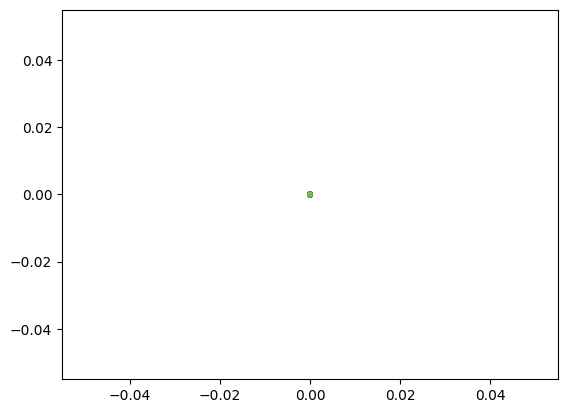

In [17]:
plt.figure()
plt.scatter(X[:,0], X[:, 1], c=y, alpha=0.4, s=10)

In [18]:
accuracy(y, y_hat)

np.float64(0.5938)